In [ ]:
import numpy as np
import os
import tensorflow as tf
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
bad_frames = '/content/drive/MyDrive/Dataset/Noisy_image_gray'

In [ ]:
from tqdm.notebook import tqdm
noisy_frames = []

for file in tqdm(sorted(os.listdir(bad_frames))):
  if any(extension in file for extension in ['.jpg', 'jpeg', '.png']):
    img = tf.keras.preprocessing.image.load_img(bad_frames + '/' + file, target_size=(256,256))
    image = tf.keras.preprocessing.image.img_to_array(img).astype('float32') / 257
    noisy_frames.append(image)
    image = np.uint8(image)

noisy_frames = np.array(noisy_frames)

  0%|          | 0/51 [00:00<?, ?it/s]

In [ ]:
print(noisy_frames.shape)

(51, 256, 256, 3)


In [ ]:
good_frames = '/content/drive/MyDrive/Dataset/Clean_image_gray'

In [ ]:
clean_frames = []
for file in tqdm(sorted(os.listdir(good_frames))):
  if any(extension in file for extension in ['.jpg', 'jpeg', '.png']):
    image = tf.keras.preprocessing.image.load_img(good_frames + '/' + file, target_size= (256,256))
    image = tf.keras.preprocessing.image.img_to_array(image).astype('float32') / 257
    clean_frames.append(image)

clean_frames = np.array(clean_frames)

  0%|          | 0/51 [00:00<?, ?it/s]

In [ ]:
print(clean_frames.shape)

(51, 256, 256, 3)


In [ ]:
# Train test split
noisy_train = noisy_frames[0:round(len(noisy_frames)*0.8)]
noisy_test = noisy_frames[round(len(noisy_frames)*0.8):]

clean_train = clean_frames[0:round(len(clean_frames)*0.8)]
clean_test = clean_frames[round(len(clean_frames)*0.8):]

In [ ]:
from keras.layers import Conv2D, MaxPool2D, GaussianNoise, Input
from keras.models import Sequential

denoising_encoder = Sequential([
    Input(shape=[256, 256, 3]),
    Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
    MaxPool2D(pool_size=2),
    Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    MaxPool2D(pool_size=2),
])

denoising_encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
Total params: 5,088
Trainable params: 5,088
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from keras.layers import Conv2DTranspose

denoising_decoder = Sequential([
    Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="selu",
                                 input_shape=[64, 64, 32]),
    Conv2DTranspose(3, kernel_size=3, strides=2, padding="SAME", activation="sigmoid", name = "Output"),
])
denoising_decoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose (Conv2DTran (None, 128, 128, 16)      4624      
_________________________________________________________________
Output (Conv2DTranspose)     (None, 256, 256, 3)       435       
Total params: 5,059
Trainable params: 5,059
Non-trainable params: 0
_________________________________________________________________


In [ ]:
denoising_ae = Sequential([denoising_encoder, denoising_decoder])

In [ ]:
denoising_ae.summary

<bound method Model.summary of <keras.engine.sequential.Sequential object at 0x7fbc6a89f390>>

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, BatchNormalization
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam,SGD

In [ ]:
denoising_ae.compile(loss="mse", optimizer=SGD(lr=0.4), metrics = ["acc"])
history = denoising_ae.fit(noisy_train, clean_train, epochs=100, batch_size=32,validation_split=0.1)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
2/2 [==============================] - 3s 522ms/step - loss: 0.0124 - acc: 0.3334 - val_loss: 0.0126 - val_acc: 0.3358
Epoch 2/100
2/2 [==============================] - 2s 412ms/step - loss: 0.0124 - acc: 0.3330 - val_loss: 0.0126 - val_acc: 0.3365
Epoch 3/100
2/2 [==============================] - 2s 403ms/step - loss: 0.0123 - acc: 0.3335 - val_loss: 0.0125 - val_acc: 0.3373
Epoch 4/100
2/2 [==============================] - 2s 408ms/step - loss: 0.0123 - acc: 0.3339 - val_loss: 0.0126 - val_acc: 0.3362
Epoch 5/100
2/2 [==============================] - 2s 413ms/step - loss: 0.0123 - acc: 0.3336 - val_loss: 0.0126 - val_acc: 0.3364
Epoch 6/100
2/2 [==============================] - 2s 399ms/step - loss: 0.0123 - acc: 0.3340 - val_loss: 0.0125 - val_acc: 0.3381
Epoch 7/100
2/2 [==============================] - 2s 412ms/step - loss: 0.0122 - acc: 0.3346 - val_loss: 0.0126 - val_acc: 0.3396
Epoch 8/100
2/2 [==============================] - 2s 403ms/step - loss: 0.0125 - a

In [ ]:
print('Final training loss \t', history.history['loss'][-1])
print('Final training accuracy \t', history.history['acc'][-1])
print('Final Validation loss \t', history.history['val_loss'][-1])
print('Final Validation accuracy\t', history.history['val_acc'][-1])

Final training loss 	 0.01106941420584917
Final training accuracy 	 0.3347930908203125
Final Validation loss 	 0.011198475956916809
Final Validation accuracy	 0.3341827392578125


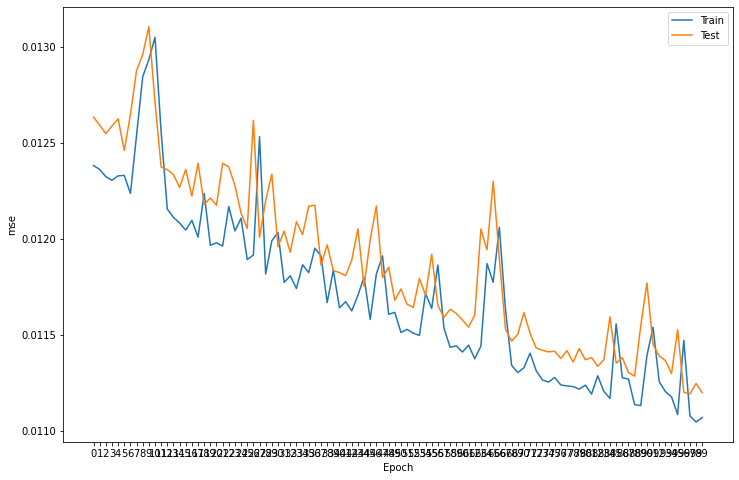

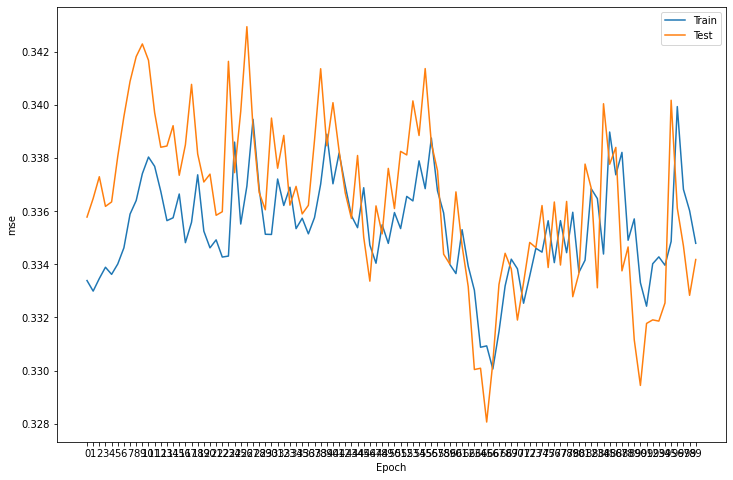

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Train', 'Test'])
plt.xlabel('Epoch')
plt.ylabel('mse')
plt.xticks(ticks=history.epoch, labels=history.epoch)
plt.show()

plt.figure(figsize=(12,8))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['Train', 'Test'])
plt.xlabel('Epoch')
plt.ylabel('mse')
plt.xticks(ticks=history.epoch, labels=history.epoch)
plt.show()

In [ ]:
results = denoising_ae.predict(noisy_test)

In [ ]:
image = np.random.randint(0, len(noisy_test))

<function matplotlib.pyplot.show>

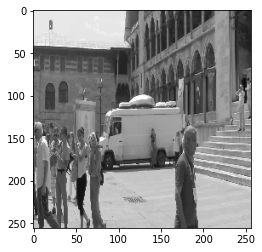

In [ ]:
plt.imshow(clean_test[image])
plt.show

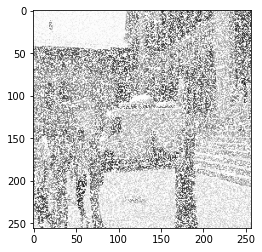

In [ ]:
plt.imshow(noisy_test[image])
plt.show()

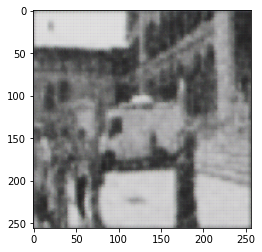

In [ ]:
plt.imshow(results[image])
plt.show()

In [ ]:
from skimage.metrics import peak_signal_noise_ratio

# predicted_images = inference_batch_images(model, noisy_test_images)
psnr_original_mean = 0
psnr_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(clean_test, noisy_test, results):
    psnr_original_mean += peak_signal_noise_ratio(gt_img, noisy_img)
    psnr_prediction_mean += peak_signal_noise_ratio(gt_img, predicted_img)

psnr_original_mean/=clean_test.shape[0]
psnr_prediction_mean/=clean_test.shape[0]
print("Original average gt-noisy PSNR ->", psnr_original_mean)
print("Predicted average gt-predicted PSNR ->", psnr_prediction_mean)

Original average gt-noisy PSNR -> 7.893719635325224
Predicted average gt-predicted PSNR -> 20.123733579327286


In [ ]:
from skimage.metrics import structural_similarity as ssim

#predicted_images = inference_batch_images(model, noisy_test_images)
ssim_original_mean = 0
ssim_prediction_mean = 0

for gt_img, noisy_img, predicted_img in zip(clean_test, noisy_test, results):
    ssim_original_mean += ssim(gt_img, noisy_img, multichannel=True, data_range=noisy_img.max() - noisy_img.min())
    ssim_prediction_mean += ssim(gt_img, predicted_img, multichannel=True, data_range=predicted_img.max() - predicted_img.min())

ssim_original_mean/=clean_test.shape[0]
ssim_prediction_mean/=clean_test.shape[0]
print("Original average gt-noisy SSIM ->", ssim_original_mean)
print("Predicted average gt-predicted SSIM ->", ssim_prediction_mean)

Original average gt-noisy SSIM -> 0.14140993551096834
Predicted average gt-predicted SSIM -> 0.4375034246147744
